# XPCS Pipeline for GiSAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [47]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

%matplotlib inline

In [48]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [49]:
#%reset

In [50]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [51]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

## Make a directory for saving results

In [52]:
CYCLE = '2016_3'
username = 'zhangz'
username = getpass.getuser()
date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [53]:
#PEO39kLiTFSI0p085_C3Lines_Paralell_40C
incidence_angle = 0.24

# Dose too low
# uid_=  'PEO39kLiTFSI0p085_C3Lines_Paralell_40C'
# uid_= uid_ + 'Run1'
# start_time, stop_time = '2016-11-13  18:31:11', '2016-11-13  18:36:27'
# uid_= uid_ + 'Run2'
# start_time, stop_time = '2016-11-13  18:36:28', '2016-11-13  18:41:34'
# uid_= uid_ + 'Run3'
# start_time, stop_time = '2016-11-13  18:41:35', '2016-11-13  18:54:10'

# Dose too low
# uid_=  'PEO39kLiTFSI0p085_C3Lines_Orthogonal_40C'
# uid_= uid_ + 'Run1'
# start_time, stop_time = '2016-11-13  19:49:51', '2016-11-13  19:55:03'
# uid_= uid_ + 'Run2'
# start_time, stop_time = '2016-11-13  19:55:04', '2016-11-13  20:00:19'
# uid_= uid_ + 'Run3'
# start_time, stop_time = '2016-11-13  20:00:19', '2016-11-13  20:13:48'

uid_=  'PEO39kLiTFSI0p085_C3Lines_Orthogonal_40C'
uid_= uid_ + 'Run1'
start_time, stop_time = '2016-11-13  21:02:25', '2016-11-13  21:09:49'
uid_= uid_ + 'Run2'
start_time, stop_time = '2016-11-13  21:41:31', '2016-11-13  21:53:23'




hdrs = db(start_time= start_time, stop_time = stop_time)

print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 10 uids are found
(7243, 'c3c28ed8-6bdd-4906-95ef-43f435e0be8f', ['/XF11ID/data/2016/11/13/d825e8aa-733c-47e9-b272_3007'])
(7242, '7008cdd2-48c9-4365-8f8c-a5abfeefd80c', ['/XF11ID/data/2016/11/13/4a0d0b4e-08e4-4275-943c_3006'])
(7241, 'a7a76e6a-f0f2-4b57-a068-5817c81084d8', ['/XF11ID/data/2016/11/13/10094d3f-bc52-4723-8f31_3005'])
(7240, 'e35a798c-9edd-47bb-b006-00c3200f4a92', ['/XF11ID/data/2016/11/13/2fd42f45-416e-4765-a4a5_3004'])
(7239, '3f99129e-4664-41b3-ae12-593f06728f86', ['/XF11ID/data/2016/11/13/d28cd690-8e36-42c9-81d1_3003'])
(7238, 'fb0900fc-a8c7-4878-8612-8daff059df9a', ['/XF11ID/data/2016/11/13/f978f953-1a85-438b-ac41_3002'])
(7237, '24ffa7d2-a608-4f52-91ff-eb58c43a6f59', ['/XF11ID/data/2016/11/13/21b400c2-5b14-4858-ad0a_3001'])
(7236, 'f96609f8-bb1e-431b-bd95-630e8c4b6266', ['/XF11ID/data/2016/11/13/a9d58019-add6-4a0b-b698_3000'])
(7235, '2c21487c-35cb-48fb-b3a7-669c3ecd80ca', ['/XF11ID/data/2016/11/13/8c1cf96e-f711-4004-b433_2999'])
(7234, '28070d72-c7a2-4250-b1

In [54]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/


In [55]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print( data_dir_)

/XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/Average/


# Don't Change these lines below here

In [56]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  image
scan_id, full-uid, data path are:  7234--28070d72-c7a2-4250-b1a4-5565ea7adaf2--/XF11ID/data/2016/11/13/d5c87ad4-b0f9-4a66-b367_2998


In [57]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/13/d5c87ad4-b0f9-4a66-b367_2998_master.h5


In [58]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    #md['sample']= 'PS205000-PMMA-207000-SMMA3'
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'
print( md['sample'])    

sample


In [59]:
imgs

<Frames>
Length: 100 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

## Overwrite Some Metadata Due to Wrong Input

In [60]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1476.0,
 'beam_center_y': 418.0,
 'count_time': 0.2,
 'detector_distance': 4.8899999,
 'frame_time': 0.20001,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [61]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.84     # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....



The sample is sample
Exposuretime=0.2 sec, Acquisition_period=0.20001 sec


In [62]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe,  path= data_dir_, md=md)

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [63]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
#mask_name = 'July30_mask.npy' #>= 160 C use this one
mask_name =  'Nov12_4Mpixel_mask.npy'


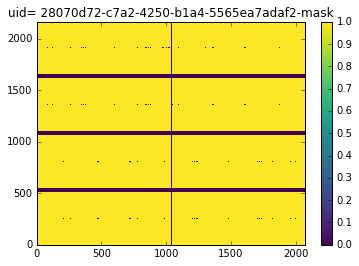

In [64]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [65]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None#NOTEBOOK_FULL_PATH

In [66]:
maskr = mask[::-1,:]
imgsr = reverse_updown( imgs )
imgsra = apply_mask( imgsr, maskr )

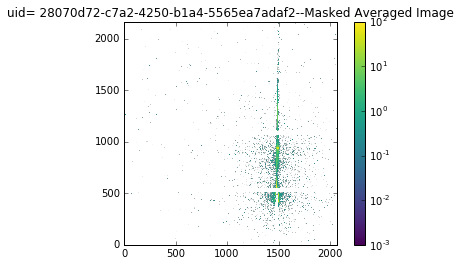

In [67]:
avg_imgr =  get_avg_img( imgsra, sampling = int(Nimg/3), plot_ = True, uid =uid)

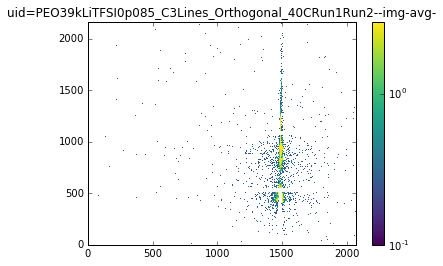

In [68]:
show_img( avg_imgr,  vmin=.1, vmax=3.0, logs=True, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_imgr

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

In [69]:
inc_x0 = 1476
inc_y0 = 418

refl_x0 = 1476
if incidence_angle == 0.24:
    refl_y0 = 965

In [70]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )

The incident_angle (alphai) is: 0.242820564431
The incident_angle (alphai) is: 0.242820564431


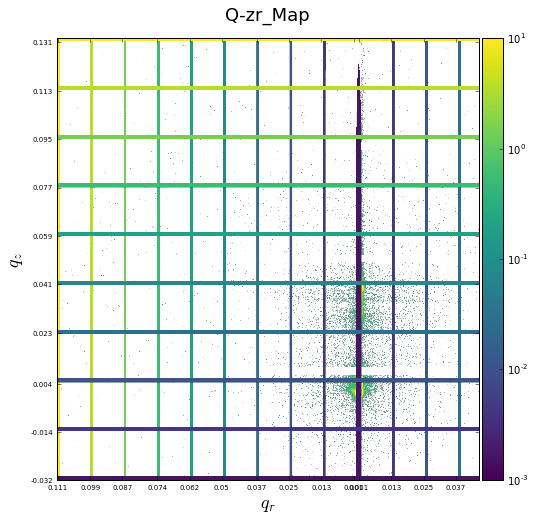

In [71]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgr, Nzline=10,  Nrline=10   )

In [72]:
qz_start = 0.035
qz_end = 0.041

qz_num= 2
qz_width = (qz_end - qz_start)/(qz_num +1)

qr_start =  0.002
qr_end = 0.025
qr_num = 6
qr_width = ( qr_end- qr_start)/(qr_num+1)

Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

In [73]:
qr_edge, qr_center = get_qedge(qr_start, qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge(qz_start, qz_end, qz_width, qz_num )
      
label_array_qz = get_qmap_label(qz, qz_edge)
label_array_qr = get_qmap_label(qr, qr_edge)

label_array_qzr, qzc, qrc = get_qzrmap(label_array_qz, label_array_qr, 
                                       qz_center, qr_center)

labels_qzr, indices_qzr = roi.extract_label_indices(label_array_qzr)
labels_qz, indices_qz = roi.extract_label_indices(label_array_qz)
labels_qr, indices_qr = roi.extract_label_indices(label_array_qr)

num_qz = len(np.unique(labels_qz))
num_qr = len(np.unique(labels_qr))
num_qzr = len(np.unique(labels_qzr))
boxes = label_array_qzr 
box_maskr = boxes*maskr

qind, pixelist = roi.extract_label_indices(box_maskr)
noqs = len(np.unique(qind))

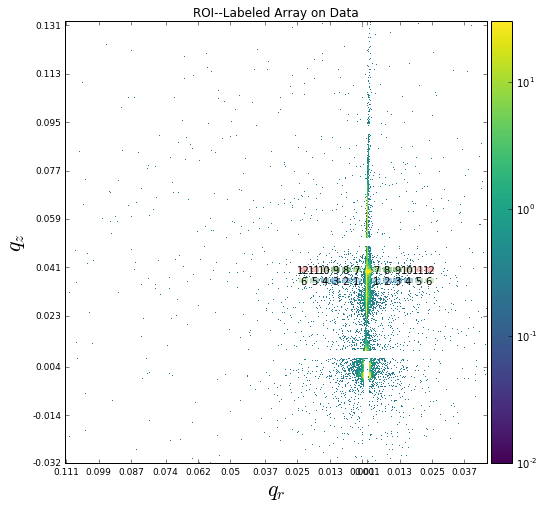

In [74]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks, alpha=0.5, save=True, path=data_dir_, uid=uid_   )

The qr_edge is:  [ 0.002       0.00528571  0.00594286  0.00922857  0.00988571  0.01317143
  0.01382857  0.01711429  0.01777143  0.02105714  0.02171429  0.025     ]
The qr_center is:  [ 0.00364286  0.00758571  0.01152857  0.01547143  0.01941429  0.02335714]
The qz_edge is:  [ 0.035  0.037  0.039  0.041]
The qz_center is:  [ 0.036  0.04 ]


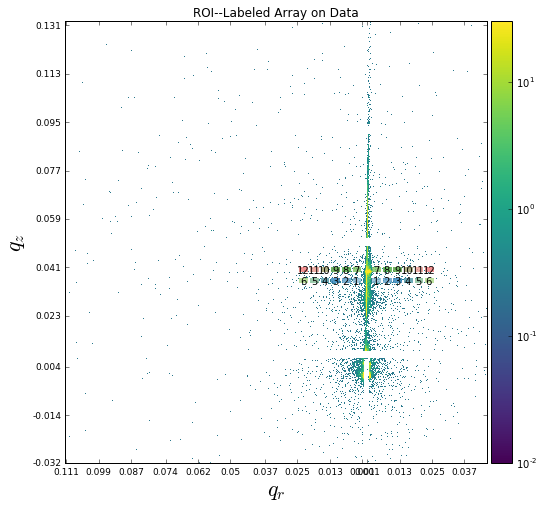

The qr_1d is saved in /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/Average/ with filename as uid=PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2--qr_1d.csv


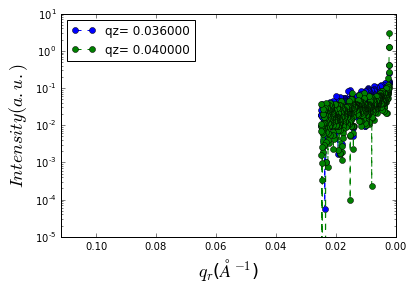

In [75]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  None,  True, ticks, .8,
                  save= True, setup_pargs=setup_pargs )

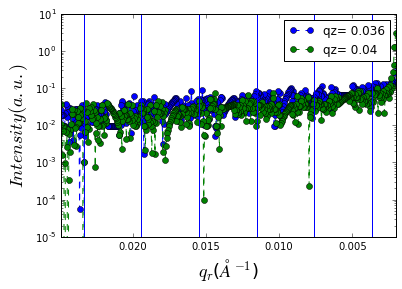

In [76]:
plot_qr_1d_with_ROI( qr_1d, qr_center, loglog=False, save=True, setup_pargs=setup_pargs )

In [77]:
md['ring_mask'] = box_maskr
md['qr_center']= qr_center
md['qr_edge'] = qr_edge
md['qz_center']= qz_center
md['qz_edge'] = qz_edge
md['beam_center_x'] = inc_x0
md['beam_center_y']=  inc_y0
md['refl_center_x'] = refl_x0
md['refl_center_y']=  refl_y0
md['incident angle'] = alphai*180/np.pi
md['data_dir'] = data_dir
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [78]:
print (len( np.where(avg_imgr)[0] ) / ( imgsra[0].size))
compress =  len( np.where(avg_imgr)[0] ) / ( imgsra[0].size) < .1  #if the photon ocupation < 0.1, do compress

print (compress)

0.02089466726412213
True


# Do loop here

In [79]:
run_num =1
sub_num =  len(uids) //run_num
print( run_num, sub_num)

1 10


The 0--th uid to be analyzed is : 28070d72-c7a2-4250-b1a4-5565ea7adaf2
hdf5 path = /XF11ID/data/2016/11/13/d5c87ad4-b0f9-4a66-b367_2998_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_28070d72-c7a2-4250-b1a4-5565ea7adaf2.cmp.
Using a multiprocess to compress the data.
It will create 1 temporary files for parallel compression.


100%|██████████| 1/1 [00:13<00:00, 13.62s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 
In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:01<00:00, 89.67it/s]


G2 calculation DONE!
The correlation function of uid= 28070d72-c7a2-4250-b1a4-5565ea7adaf2 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/28070d72-c7a2-4250-b1a4-5565ea7adaf2/g2-28070d72-c7a2-4250-b1a4-5565ea7adaf2-20161113-2154-.csv


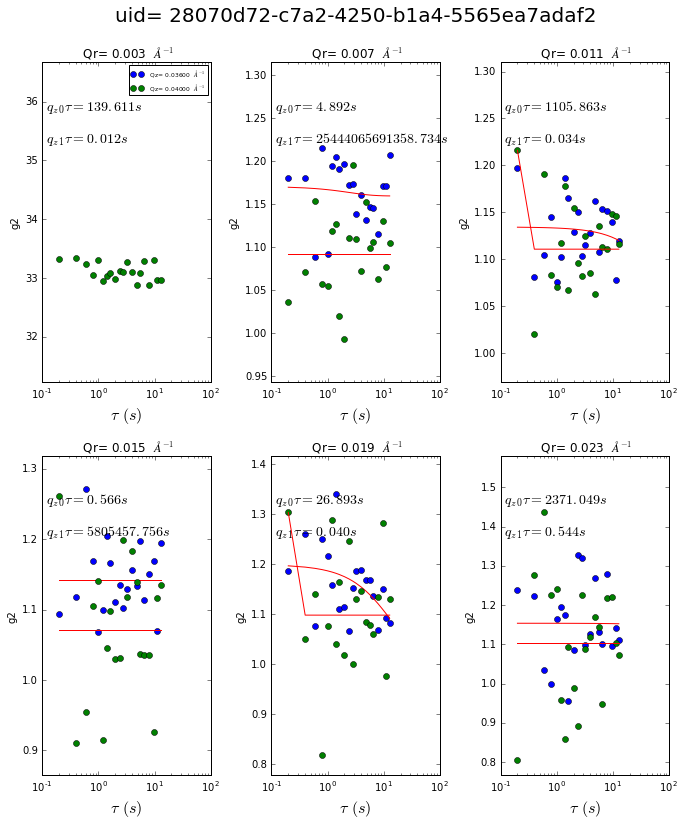

The fitted diffusion coefficient D0 is:  8.673e+02   A^2S-1
The fitted diffusion coefficient D0 is:  2.999e+04   A^2S-1


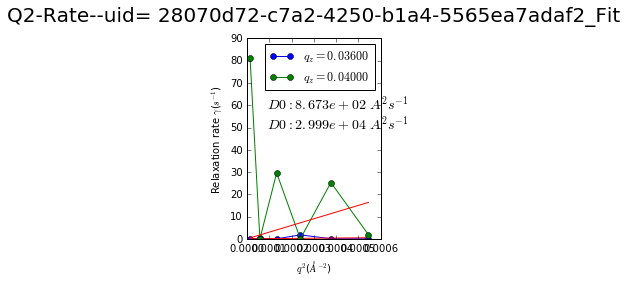

****************************************

The 1--th uid to be analyzed is : 2c21487c-35cb-48fb-b3a7-669c3ecd80ca
hdf5 path = /XF11ID/data/2016/11/13/8c1cf96e-f711-4004-b433_2999_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_2c21487c-35cb-48fb-b3a7-669c3ecd80ca.cmp.
Using a multiprocess to compress the data.
It will create 1 temporary files for parallel compression.


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 
In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:00<00:00, 161.99it/s]


G2 calculation DONE!
The correlation function of uid= 2c21487c-35cb-48fb-b3a7-669c3ecd80ca is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/2c21487c-35cb-48fb-b3a7-669c3ecd80ca/g2-2c21487c-35cb-48fb-b3a7-669c3ecd80ca-20161113-2155-.csv


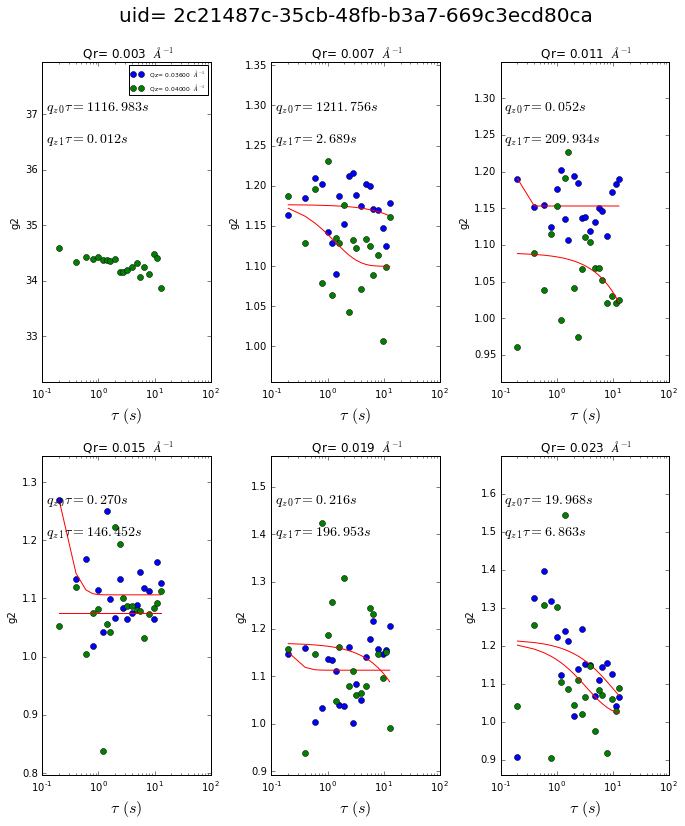

The fitted diffusion coefficient D0 is:  1.010e+04   A^2S-1
The fitted diffusion coefficient D0 is:  2.329e+03   A^2S-1


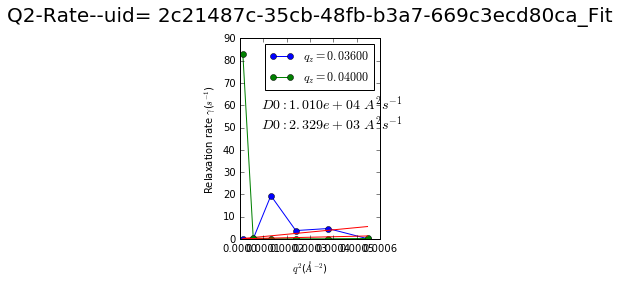

****************************************

The 2--th uid to be analyzed is : f96609f8-bb1e-431b-bd95-630e8c4b6266
hdf5 path = /XF11ID/data/2016/11/13/a9d58019-add6-4a0b-b698_3000_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_f96609f8-bb1e-431b-bd95-630e8c4b6266.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:13<00:00,  8.05s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:00<00:00, 157.12it/s]


G2 calculation DONE!
The correlation function of uid= f96609f8-bb1e-431b-bd95-630e8c4b6266 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/f96609f8-bb1e-431b-bd95-630e8c4b6266/g2-f96609f8-bb1e-431b-bd95-630e8c4b6266-20161113-2156-.csv


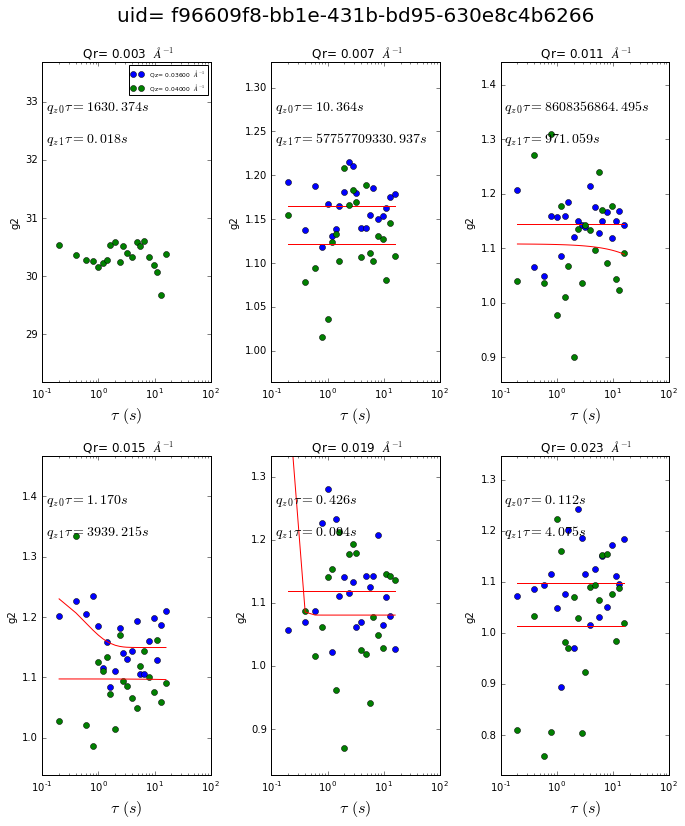

The fitted diffusion coefficient D0 is:  1.151e+04   A^2S-1
The fitted diffusion coefficient D0 is:  9.478e+03   A^2S-1


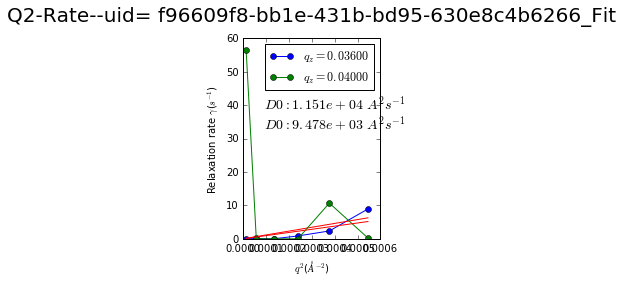

****************************************

The 3--th uid to be analyzed is : 24ffa7d2-a608-4f52-91ff-eb58c43a6f59
hdf5 path = /XF11ID/data/2016/11/13/21b400c2-5b14-4858-ad0a_3001_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_24ffa7d2-a608-4f52-91ff-eb58c43a6f59.cmp.
Using a multiprocess to compress the data.
It will create 1 temporary files for parallel compression.


100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 
In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:00<00:00, 162.47it/s]


G2 calculation DONE!
The correlation function of uid= 24ffa7d2-a608-4f52-91ff-eb58c43a6f59 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/24ffa7d2-a608-4f52-91ff-eb58c43a6f59/g2-24ffa7d2-a608-4f52-91ff-eb58c43a6f59-20161113-2156-.csv


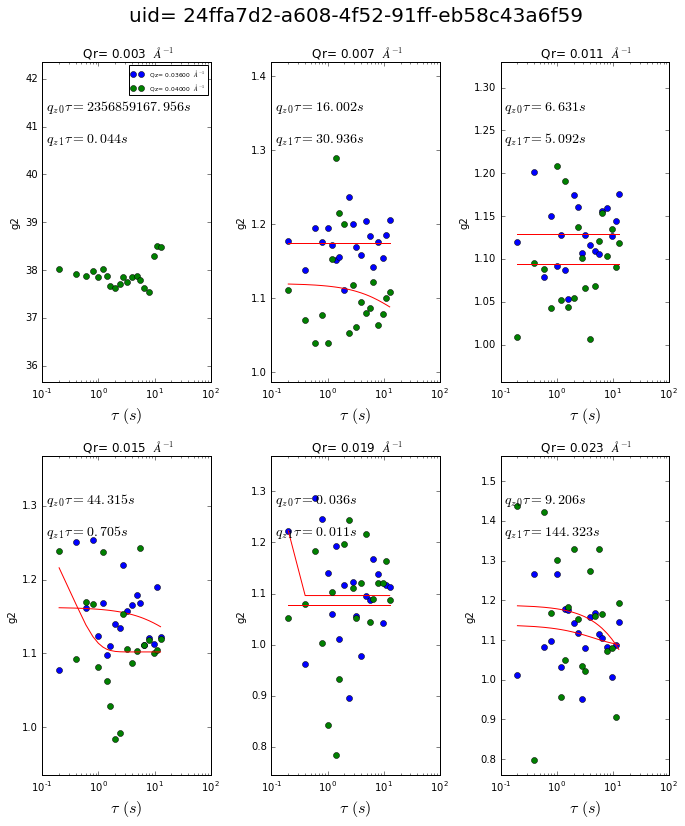

The fitted diffusion coefficient D0 is:  2.055e+04   A^2S-1
The fitted diffusion coefficient D0 is:  6.985e+04   A^2S-1


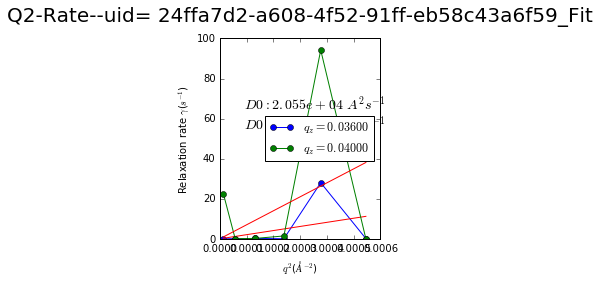

****************************************

The 4--th uid to be analyzed is : fb0900fc-a8c7-4878-8612-8daff059df9a
hdf5 path = /XF11ID/data/2016/11/13/f978f953-1a85-438b-ac41_3002_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_fb0900fc-a8c7-4878-8612-8daff059df9a.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:17<00:00, 10.39s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:00<00:00, 165.60it/s]


G2 calculation DONE!
The correlation function of uid= fb0900fc-a8c7-4878-8612-8daff059df9a is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/fb0900fc-a8c7-4878-8612-8daff059df9a/g2-fb0900fc-a8c7-4878-8612-8daff059df9a-20161113-2157-.csv


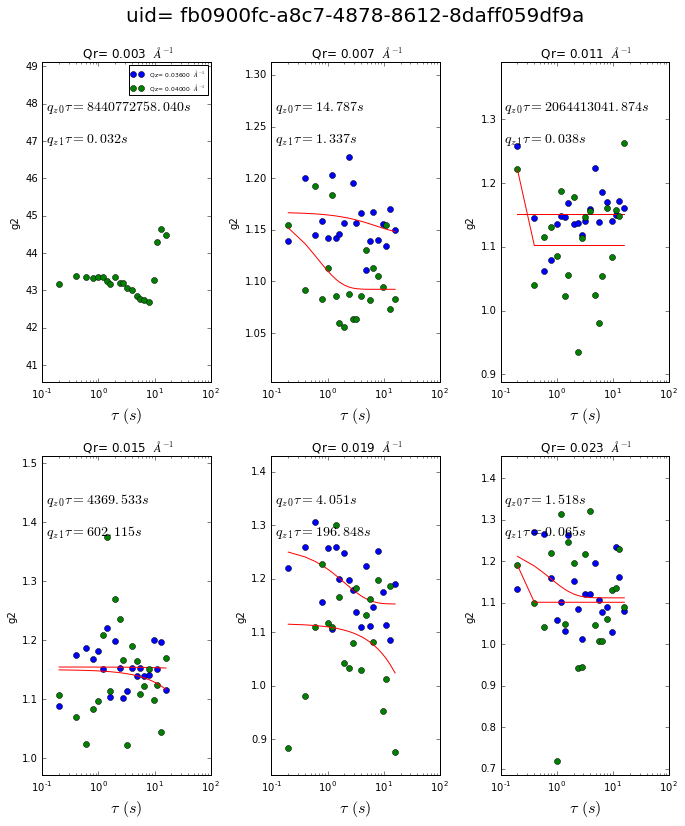

The fitted diffusion coefficient D0 is:  8.806e+02   A^2S-1
The fitted diffusion coefficient D0 is:  2.393e+04   A^2S-1


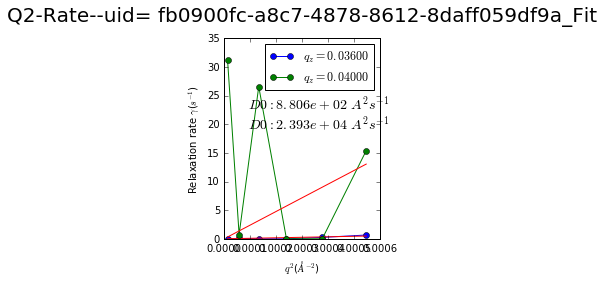

****************************************

The 5--th uid to be analyzed is : 3f99129e-4664-41b3-ae12-593f06728f86
hdf5 path = /XF11ID/data/2016/11/13/d28cd690-8e36-42c9-81d1_3003_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_3f99129e-4664-41b3-ae12-593f06728f86.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:13<00:00,  7.99s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:00<00:00, 166.84it/s]


G2 calculation DONE!
The correlation function of uid= 3f99129e-4664-41b3-ae12-593f06728f86 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/3f99129e-4664-41b3-ae12-593f06728f86/g2-3f99129e-4664-41b3-ae12-593f06728f86-20161113-2157-.csv


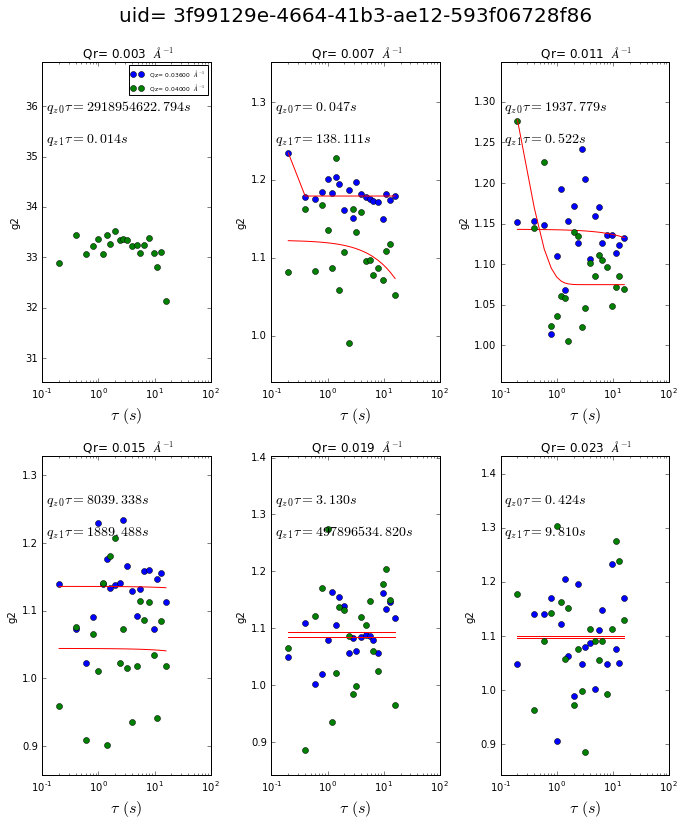

The fitted diffusion coefficient D0 is:  5.077e+03   A^2S-1
The fitted diffusion coefficient D0 is:  2.405e+03   A^2S-1


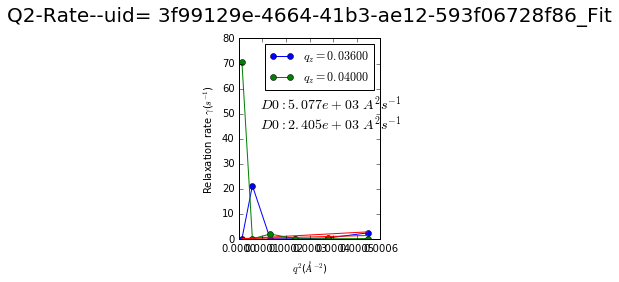

****************************************

The 6--th uid to be analyzed is : e35a798c-9edd-47bb-b006-00c3200f4a92
hdf5 path = /XF11ID/data/2016/11/13/2fd42f45-416e-4765-a4a5_3004_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_e35a798c-9edd-47bb-b006-00c3200f4a92.cmp.
Using a multiprocess to compress the data.
It will create 1 temporary files for parallel compression.


100%|██████████| 1/1 [00:11<00:00, 11.09s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 
In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:00<00:00, 166.24it/s]


G2 calculation DONE!
The correlation function of uid= e35a798c-9edd-47bb-b006-00c3200f4a92 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/e35a798c-9edd-47bb-b006-00c3200f4a92/g2-e35a798c-9edd-47bb-b006-00c3200f4a92-20161113-2158-.csv


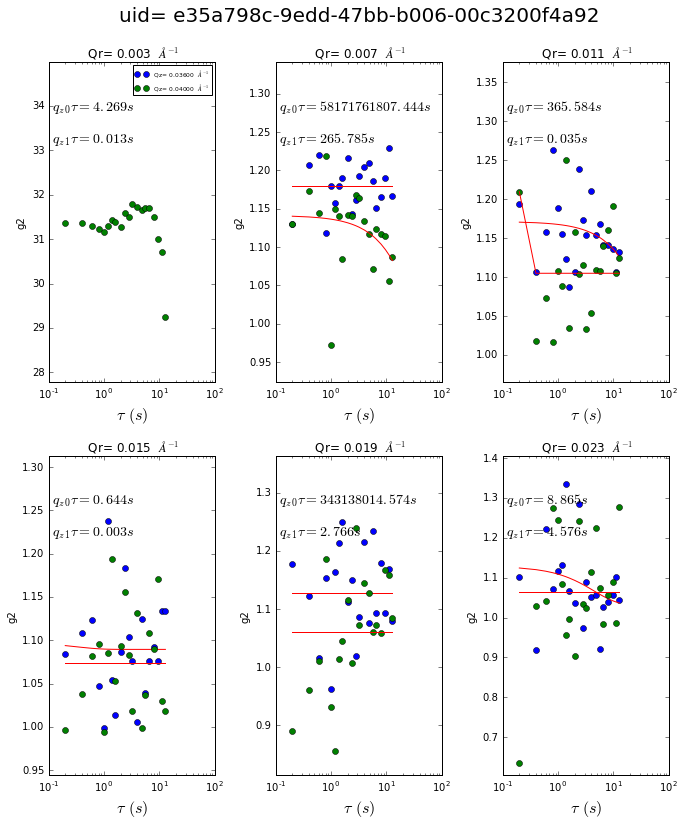

The fitted diffusion coefficient D0 is:  8.431e+02   A^2S-1
The fitted diffusion coefficient D0 is:  1.561e+05   A^2S-1


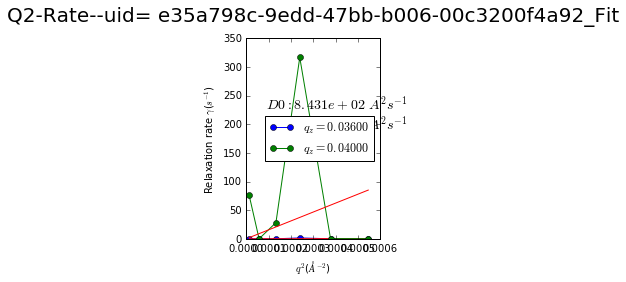

****************************************

The 7--th uid to be analyzed is : a7a76e6a-f0f2-4b57-a068-5817c81084d8
hdf5 path = /XF11ID/data/2016/11/13/10094d3f-bc52-4723-8f31_3005_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_a7a76e6a-f0f2-4b57-a068-5817c81084d8.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:16<00:00, 10.25s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:01<00:00, 82.33it/s]


G2 calculation DONE!
The correlation function of uid= a7a76e6a-f0f2-4b57-a068-5817c81084d8 is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/a7a76e6a-f0f2-4b57-a068-5817c81084d8/g2-a7a76e6a-f0f2-4b57-a068-5817c81084d8-20161113-2158-.csv


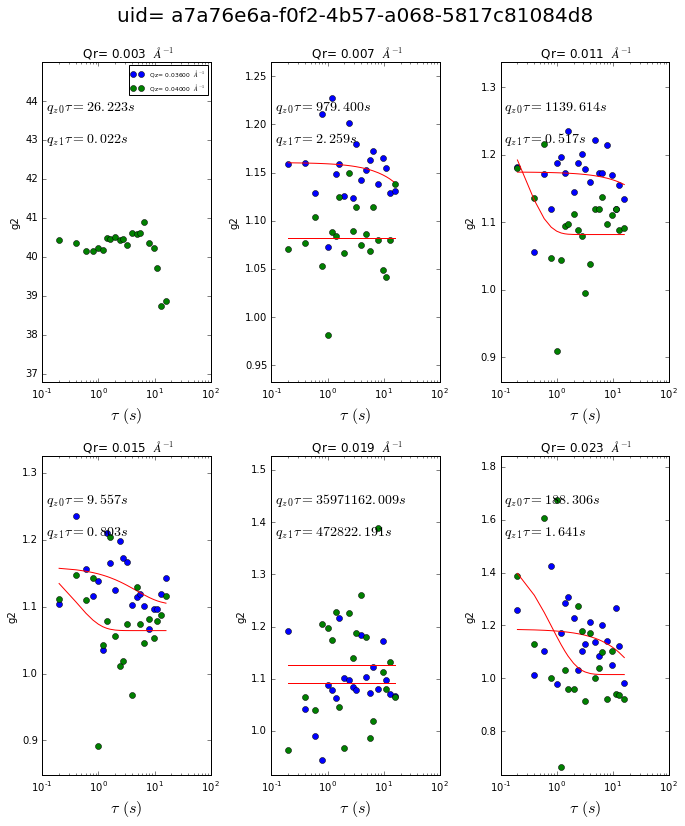

The fitted diffusion coefficient D0 is:  5.524e+01   A^2S-1
The fitted diffusion coefficient D0 is:  2.913e+03   A^2S-1


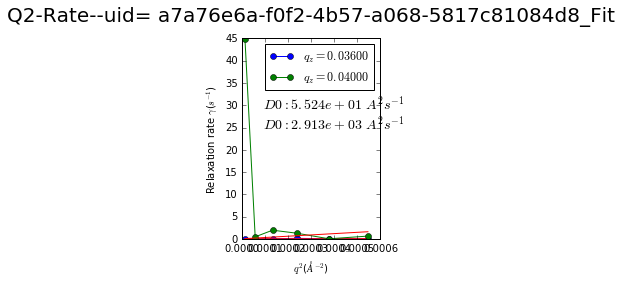

****************************************

The 8--th uid to be analyzed is : 7008cdd2-48c9-4365-8f8c-a5abfeefd80c
hdf5 path = /XF11ID/data/2016/11/13/4a0d0b4e-08e4-4275-943c_3006_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_7008cdd2-48c9-4365-8f8c-a5abfeefd80c.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:17<00:00, 10.53s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:00<00:00, 158.27it/s]


G2 calculation DONE!
The correlation function of uid= 7008cdd2-48c9-4365-8f8c-a5abfeefd80c is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/7008cdd2-48c9-4365-8f8c-a5abfeefd80c/g2-7008cdd2-48c9-4365-8f8c-a5abfeefd80c-20161113-2159-.csv


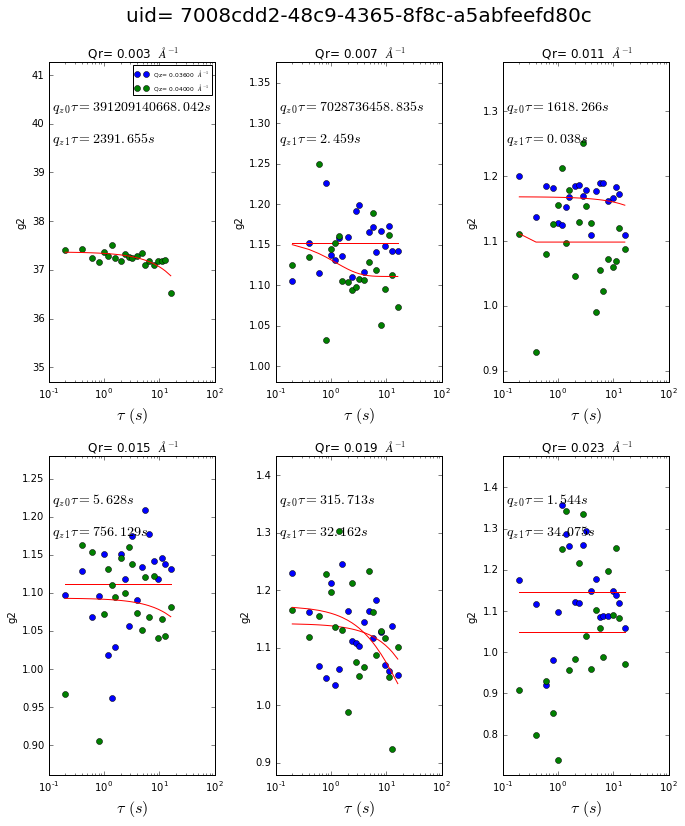

The fitted diffusion coefficient D0 is:  7.667e+02   A^2S-1
The fitted diffusion coefficient D0 is:  6.883e+03   A^2S-1


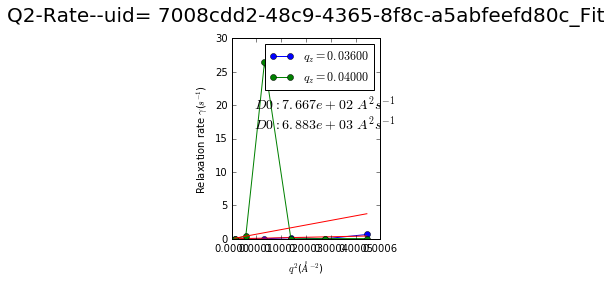

****************************************

The 9--th uid to be analyzed is : c3c28ed8-6bdd-4906-95ef-43f435e0be8f
hdf5 path = /XF11ID/data/2016/11/13/d825e8aa-733c-47e9-b272_3007_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_c3c28ed8-6bdd-4906-95ef-43f435e0be8f.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:14<00:00,  8.76s/it]


No bad frames are involved.
Combining the seperated compressed files together...
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:00<00:00, 155.08it/s]


G2 calculation DONE!
The correlation function of uid= c3c28ed8-6bdd-4906-95ef-43f435e0be8f is saved with filename as /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/c3c28ed8-6bdd-4906-95ef-43f435e0be8f/g2-c3c28ed8-6bdd-4906-95ef-43f435e0be8f-20161113-2200-.csv


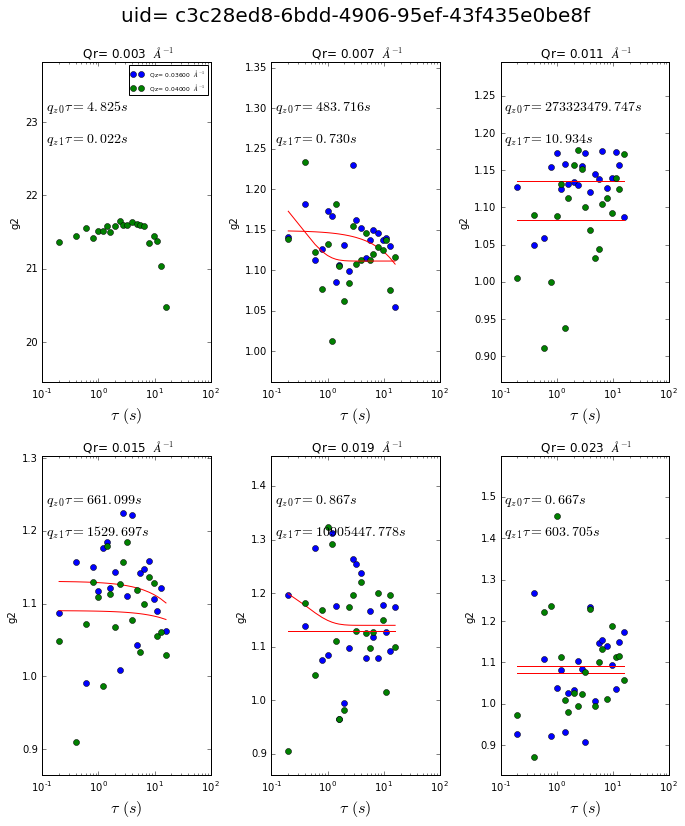

The fitted diffusion coefficient D0 is:  2.425e+03   A^2S-1
The fitted diffusion coefficient D0 is:  1.319e+03   A^2S-1


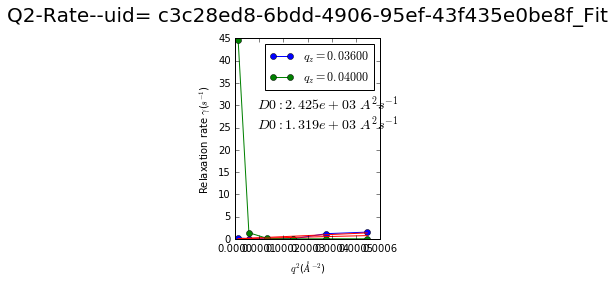

****************************************



In [80]:
g2s, taus, useful_uids  = multi_uids_gisaxs_xpcs_analysis(  
                    uids, md, run_num, sub_num, fit= True, compress=True  )


## Create PDF report for each uid

In [81]:
useful_uids

{1: {1: '28070d72-c7a2-4250-b1a4-5565ea7adaf2',
  2: '2c21487c-35cb-48fb-b3a7-669c3ecd80ca',
  3: 'f96609f8-bb1e-431b-bd95-630e8c4b6266',
  4: '24ffa7d2-a608-4f52-91ff-eb58c43a6f59',
  5: 'fb0900fc-a8c7-4878-8612-8daff059df9a',
  6: '3f99129e-4664-41b3-ae12-593f06728f86',
  7: 'e35a798c-9edd-47bb-b006-00c3200f4a92',
  8: 'a7a76e6a-f0f2-4b57-a068-5817c81084d8',
  9: '7008cdd2-48c9-4365-8f8c-a5abfeefd80c',
  10: 'c3c28ed8-6bdd-4906-95ef-43f435e0be8f'}}

* Create multi PDF report for each uid

In [82]:
#create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir )
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir, append_name='_1' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/XPCS_Analysis_Report_for_uid=28070d72-c7a2-4250-b1a4-5565ea7adaf2_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/XPCS_Analysis_Report_for_uid=2c21487c-35cb-48fb-b3a7-669c3ecd80ca_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/XPCS_Analysis_Report_for_uid=f96609f8-bb1e-431b-bd95-630e8c4b6266_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTF

### Attach each g2 result to the corresponding olog entry

In [83]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [84]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [85]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s_1.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
     
    

## Create one PDF including all uids

In [86]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_, report_type='gisaxs' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/yuzhang/Results/PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2/XPCS_Analysis_Report_for_uid=PEO39kLiTFSI0p085_C3Lines_Orthogonal_40CRun1Run2.pdf
****************************************


# Do average Here

In [87]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            g2s_average[key] +=  g2s[key][sub_key]
            i +=1
            print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
            #print( 'sub= %s,Doing average here'%sub_key)
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
sub= 3,Can not Doing average here
Run= 1--sub_run= 4-- pass
sub= 5,Can not Doing average here
sub= 6,Can not Doing average here
Run= 1--sub_run= 7-- pass
sub= 8,Can not Doing average here
sub= 9,Can not Doing average here
sub= 10,Can not Doing average here


# Save Data

In [88]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                  path=data_dir, uid= 'Average@run-%s'%( key       ))
    save_gisaxs_g2(    g2s_average[key], res_pargs )


ValueError: total size of new array must be unchanged

# Plot Avergaed Data

ValueError: x and y must have same first dimension

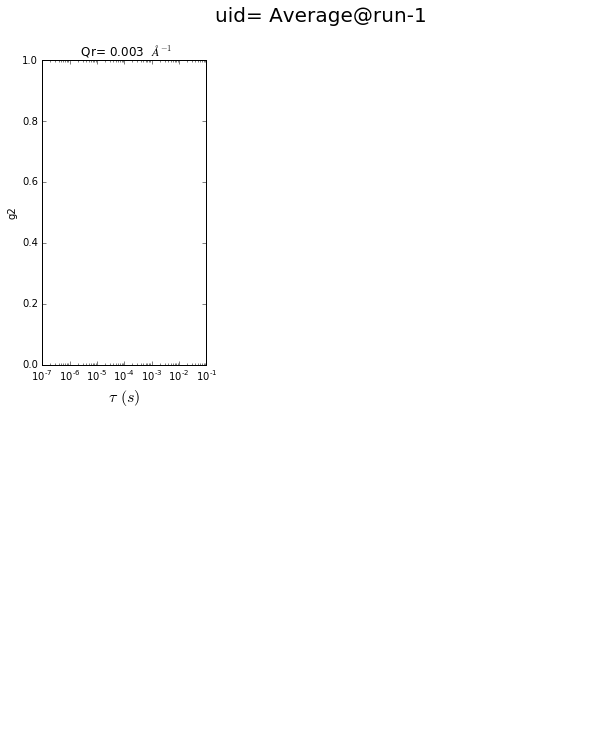

In [89]:
if True:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                      path=data_dir, uid= 'Average@run-%s'%( key       ))
        plot_gisaxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.15], res_pargs=res_pargs, one_plot=True)    

# Fit Avergaed Data

In [ ]:
fit = False

In [ ]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, qz_center=qz_center, qr_center=qr_center,
                        path=data_dir_, uid=  uid_ + '@run--%s'%key )                      

        fit_result = fit_gisaxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.15], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.34,'alpha':1.0,'relaxation_rate':0.1},
                              one_plot= True)        
        
        fit_qr_qz_rate(  qr_center, qz_center, fit_result, power_variable= False,
                  uid=uid_ + '@run--%s'%key, path= data_dir_ )        
        psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )


# Create a report for the avergae g2

In [ ]:
data_dir_

In [ ]:
create_report = True

In [ ]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

In [ ]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, out_dir = pdf_out_dir, filename = filename,
                         report_type = 'gisaxs' )
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  

# The End!

In [ ]:
last_uid_num = len( useful_uids[1] )

In [ ]:
uid_last = useful_uids[1][    last_uid_num     ]
print( uid_last )

In [ ]:
#uid_ = uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )